# Round 2 : Create summary tables that address therapeutics, interventions, and clinical studies

We have tried to solve the therapeutics, interventions, and clinical studies task associated to Covid-19 which deals in creating summary tables 
for the target information requested.This notebook serves a solutioning platform to extract and identify
the key elements associated to therapeutics, interventions, and clinical related queries. The team 
involved here does not have medical domain expertise but has tried to use open source domain related information for domain reference and 
leverage NLP skills on it to come up with a final solution.

The pipeline tries to accomplish the following tasks:-

Create the Target summary tables with the information requested.
It ensures any addition to knowledge corpus would be a benefactor in repopulating the summaries.
The knowledge domain can be enhanced and more relevant searches can be accomplished
The pipeline can be reusable for any similar information extraction task.
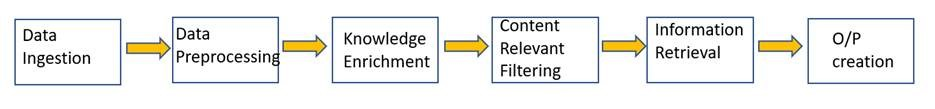

The corpus and metadata was ingested into the pipeline.As part of the metadata enrichment , we created 
knowledge dictionaries on which filters were applied to filter the knowledge base having the information
needed to derive the outputs. Once the refined knowledge base was created, context based search was used
to identify the relevant articles. By using a hybrid approach of rule based and bert based approach, the
final results were populated into the Target summary tables to encompass all elements requested as part
of the Task.For columns "General Outcome/Conclusion Excerpt" and "Primary Endpoint(s) of Study" data were
extracted using T5 summarization model.

This pipeline will take around 5-6 hours to run on CPU for whole data.

References: https://www.kaggle.com/mlconsult/round-2-working-example-material-studies-covid-19/notebook








# load the needed python packages

In [ ]:
import pandas as pd
import numpy as np
import functools
import re
import os
import random
import json
from pprint import pprint
from copy import deepcopy
import math
from IPython.core.display import display, HTML
### BERT QA
import torch
!pip install -q transformers --upgrade
from transformers import *
modelqa = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
#T5 summarization
!pip install transformers --upgrade
from transformers import T5Tokenizer, T5ForConditionalGeneration
print ('packages loaded')

# Load the full text articles from the dataset which includes metadata and respective pdf_json file texts

In [ ]:
def search_relevant_docs(df):
    keywords=['hypercoagulable','efficacy']
    df=df[df['abstract'].str.contains('|'.join(keywords))]
    return df

In [ ]:
# load the meta data from the CSV file
df=pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
#print ('ALL CORD19 articles',df.shape)
#fill na fields
df=df.fillna('no data provided')
#drop duplicate titles
df = df.drop_duplicates(subset='title', keep="first")
#keep only 2020 dated papers
df=df[df['publish_time'].str.contains('2020')]
# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()+df["title"].str.lower()
#print ('Keep only COVID-19 related articles',df.shape)
df=search_relevant_docs(df)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body


for index, row in df.iterrows():
    #print (row['pdf_json_files'])
    if 'no data provided' not in row['pdf_json_files'] and os.path.exists('/kaggle/input/CORD-19-research-challenge/'+row['pdf_json_files'])==True:
        with open('/kaggle/input/CORD-19-research-challenge/'+row['pdf_json_files']) as json_file:
            #print ('in loop')
            data = json.load(json_file)
            body=format_body(data['body_text'])
            #print (body)
            body=body.replace("\n", " ")
            text=row['abstract']+' '+body.lower()
            df.loc[index, 'abstract'] =text

df=df.drop(['pdf_json_files'], axis=1)
df=df.drop(['sha'], axis=1)
df.head()


In [ ]:
len(df)

In [ ]:
df=df.sort_values(by=['publish_time'], ascending=False)

In [ ]:
df.reset_index(inplace = True,drop=True)

# Final Corpus Creation Based On Keyword Based Search Against Queries mentioned for given task

In [ ]:
df1= df[['title','publish_time','journal','url','abstract','doi','cord_uid']]
#Make a copy to work with
df_relevant=df1.copy()
#list of study type
study_type=['Cross-sectional study', 'retrospective review', 'Expert review','Prospective observational study', '-','Retrospective observational study', 'Case-series', 'Case series',
'Retrospective observational','Retrospective Observational Study','Prospective Observational Study', 'Simulation', 'Expert Review',
'Case Series', 'Systematic Review', 'Case Report', 'Editorial']
#checking for study type
df_relevant['Study Type']=''
for i in range(0,len(study_type)):
    for j in range(0,len(df_relevant['abstract'])):
        if re.search(study_type[i],df_relevant['abstract'].iloc[j], re.IGNORECASE):
            df_relevant['Study Type'].iloc[j]=study_type[i]
        else:
            if df_relevant['Study Type'].iloc[j]=='':
                df_relevant['Study Type'].iloc[j]='no data found'

#list of Therapeutic method(s)
Therapeutic_methods=['25μg/Kg/bodyweight tiroﬁban as bolus infusion, followed by a continuous infusion of 0.15μg/Kg/body weight per minute for 48 hours. Before tiroﬁban, patients received acetylsalicylic acid 250 mg infusion and oral clopidogrel 300 mg; both were continued at a dose of 75 mg daily for 30 days. Fondaparinux2.5 mg/day sub-cutaneous was given for the duration of the hospital stay. All controls were receiving prophylactic or therapeutic dose heparin, according to local standard operating procedures',
'Nifedipine and Amlodipine','Low molecular weight heparin;  Tissue Plasminogen Activator (TPA) or defbrotide','systemic anticoagulation with a weight-adjusted therapeutic regimen of low-molecular-weight heparin or intravenous heparin infusion',
'Thromboprophylaxis','Low Molecular Weight Heparin (LMWH)','Thromboprophylaxis with low-molecularweight heparin; prophylactic dosage Thromboprophylaxis; intermediate-dosage thromboprophylaxis; therapeutic-dose Thromboprophylaxis',
'Heparin','Prophylactic anticoagulation (drug/dose decision left to treating physician)','Unfractionated heparin, LMWH, Topical citrate local anticoagulation, argatroban/bivaliruden (in COVID patients experiencing HIT), Goal-directed replacement therapy (fresh frozen plasma, platelets), recombinant factor VII, plasma exchange (in patients experiencing liver failure)',
'Dipyramidole','LMWH','VTE Prophylaxis (Unfractionated heparin, LMWH, pneumatic compression devices)','Heparin, standard-dose LMWH, Fondaparinux',
'Tissue Plasminogen Activator (tPA)','therapeutic plasma exchange','Heparin (94 with LMWH, 5 with unfractionated heparin)','Dipyridamole',
'Umifenovir','Alpha-1 Adrenoreceptor Antagonists','α-Lipoic acid','Computer aided drug design technique to identify potential drug candidates',
'Lopinavir/ritonavir (LPV/r) or arbidol monotherapy','Tocilizumab','Hydroxychloroquine','Remdesivir','A review of multiple potential therapeutic options',
'Convalescent Plasma','Literature review of 4 classes: (a) anti-viral and anti-inflammatory drugs, (b) anti-malaria drugs, (c) traditional Chinese drugs and (d) other treatments/drugs.',
'Hydroxychloroquine and azithromycin combination','Medicinal Plants','Convalescent Plasma (CP)','High-dose intravenous immunoglobulin (IVIg)',
'Hydroxychloroquine and azithromycin','Acetazolamide, Nifedipine and Phosphodiesterase Inhibitors','Lopinavir-Ritonavir','Favipiravir',
'Antivirals, antibacterials, glucocorticoids, and traditional Chinese medicine','Chloroquine phosphate','Corticosteroids','Chloroquine',
'Traditional Chinese Medicine','ECMO','Multiple drugs','IFN-β-1a','A review of the following 10 predicted commercial medicines (potential inhibitors for 2019-nCoV Mpro): Colistin, Valrubicin, Icatibant, Bepotastine, Epirubicin, Epoprostenol, Vapreotide, Aprepitant, Caspofungin, and Perphenazine.',
'Baricitinib','Remdesivir and chloroquine','Review of multiple potential anti-virals']

#checking for therapeutic method
df_relevant['Therapeutic method(s) utilized/assessed']=''
for i in range(0,len(Therapeutic_methods)):
    for j in range(0,len(df_relevant['abstract'])):
        if re.search(Therapeutic_methods[i],df_relevant['abstract'].iloc[j], re.IGNORECASE):
            df_relevant['Therapeutic method(s) utilized/assessed'].iloc[j]=Therapeutic_methods[i]
        else:
            if df_relevant['Therapeutic method(s) utilized/assessed'].iloc[j]=='':
                df_relevant['Therapeutic method(s) utilized/assessed'].iloc[j]='no data found'

#list of severity
severity=['patients with laboratory conﬁrmed SARS-CoV-2 infection, severe respiratory failure requiring helmet continuous positive airway pressure (CPAP), bilateral pulmonary inﬁltrates and a prothrombotic state identiﬁed as a D-dimer>3 times the upper limit of normal. Five patients matched for age, Ddimer value and SOFA score formed the control group.',
       'at or above the age of 65 and that expired or survived to discharge from a community hospital',
       '-', 'acute medical condition; outpatient', 'Severe',
       'A total of 61 (16%) patients required intensive care; the remaining 327 patients were admitted to general wards',
       'ICU-level',
       'Severe: The diagnosis of severe case was made if patients met any of the following criteria: (1) respiratory rate ≥ 30 breaths/min; (2) SpO2≤93% while breathing room air; (3) PaO2/FiO2≤300 mmHg. A critically ill case  was diagnosed if any of the following criteria was met: (1) respiratory failure which requiring mechanical ventilation; (2) shock; (3) combined with other organ failure and need to be admitted to  ICU.',
       'Critically ill, mechanically ventilated, COVID-19 positive patients with ARDS',
       'All patients required ≥2 vasopressors and all patients receiving TPE required mechanical ventilator support.',
       'Severe per Chinese CDC', 'Cough and shortness of breath','Varied', '-', 'Severe', 'Mild / moderate', 'MIld / moderate']
#checking for severity
df_relevant['Severity of Disease']=''
for i in range(0,len(severity)):
    for j in range(0,len(df_relevant['abstract'])):
        if re.search(severity[i],df_relevant['abstract'].iloc[j], re.IGNORECASE):
            df_relevant['Severity of Disease'].iloc[j]=severity[i]
        else:
            if df_relevant['Severity of Disease'].iloc[j]=='':
                df_relevant['Severity of Disease'].iloc[j]='no data found'

#checking for Clinical Improvement (Y/N)
clinical_improvement=['Clinical Improvement','Clinical','Improvement','recovery','clinical inhancement']
df_relevant['Clinical Improvement (Y/N)']=''
for i in range(0,len(clinical_improvement)):
    for j in range(0,len(df_relevant['abstract'])):
        if re.search(clinical_improvement[i],df_relevant['abstract'].iloc[j], re.IGNORECASE):
            df_relevant['Clinical Improvement (Y/N)'].iloc[j]='Y'
        else:
            if df_relevant['Clinical Improvement (Y/N)'].iloc[j]=='':
                df_relevant['Clinical Improvement (Y/N)'].iloc[j]='N'

# Below is the method which is used for BERT Question-Answering and extracting respective context to fed in to Model

In [ ]:
# BERT pretrained question answering module
def answer_question(question,text,model):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_text = "[CLS] " + question + " [SEP] " + text + " [SEP]"
    input_ids = tokenizer.encode(input_text)
    token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer=(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    answer=answer.replace(' ##','')
    return answer

# Below Method is key method where T5 model is used for summarization of two columns and respective Output CSV are getting generated

In [ ]:
def get_data(keyword):
    ########------------- filter respective data based on keywords -----------############
    df2 = df_relevant[df_relevant['abstract'].str.contains(keyword)]
    df_results = pd.DataFrame(columns=['Date','Study','Study Link', 'Journal','Therapeutic method(s) utilized/assessed', 'Sample Size','Severity of Disease', 'General Outcome/Conclusion Excerpt','Primary Endpoint(s) of Study','Clinical Improvement (Y/N)','Study Type','Added On'])
    for index, row in df2.iterrows():
        ### --------- get Detection Method Type. Call BERT model for Question Answering if we dont get answer from our existing list of Methods---------  ####
        method_type=row['Therapeutic method(s) utilized/assessed']
        if method_type=='no found data':
            method_q='what type of Therapeutic study or method or detection analysis review was utilized or assessed?'
            method_design=row['abstract'][0:1000]
            method_type=answer_question(method_q,method_design,modelqa)
        ### --------- get Study Type. Call BERT model for Question-Answering if we dont get answer from our existing list of Study Type---------  ####    
        study_type =row['Study Type']
        if study_type =='no found data':       
            study_q='what type of study analysis review was conducted or undertaken?'
            study_design=row['abstract'][0:1000]
            study_type=answer_question(study_q,study_design,modelqa)
        
        ### --------- get Study Type. Call BERT model for Question-Answering if we dont get answer from our existing list of Study Type---------  ####    
        severity_of_disease =row['Severity of Disease']
        if severity_of_disease =='no found data':       
            study_q='what are the symptoms of severity of disease?'
            study_design=row['abstract'][0:1000]
            severity_of_disease=answer_question(study_q,study_design,modelqa)
            
        ### --------- get sample size using BERT for Question-Answering ------------  ####
        sample_q='how many patients cases studies were included collected or enrolled?'
        sample=row['abstract'][0:1000]
        sample=sample.replace('covid-19','')
        sample_size=answer_question(sample_q,sample,modelqa)
        if '[SEP]' in sample_size or '[CLS]' in sample_size:
            sample_size='-' 
            
                 
    
        ###-------------- get Add_on----------------------#########
        added_on =['4/25/2020','4/23/2020','5/9/2020','5/12/2020','5/12/2020','5/17/2020','5/27/2020']
        
        ###---using T5 for two columns---##
        from transformers import pipeline
        summarization_pipeline = pipeline(task='summarization', model="t5-small") 
        output=summarization_pipeline(row['abstract'][0:1000], min_length=30, max_length=300, top_k=100, top_p=0.8)
        General_Outcome_Conclusion_Excerpt=output[0]['summary_text']
        
        ###---using T5 for second column---##
        summarization_pipeline = pipeline(task='summarization', model="t5-small") 
        output_new=summarization_pipeline(General_Outcome_Conclusion_Excerpt, min_length=30, max_length=150, top_k=100, top_p=0.8)
        Primary_Endpoint_of_Study=output_new[0]['summary_text']
        
        ## ------------------  get data frame to append --------------------------##
        link=row['doi']
        linka='https://doi.org/'+link
        to_append = [row['publish_time'],row['title'],linka,row['journal'],method_type,sample_size,severity_of_disease,General_Outcome_Conclusion_Excerpt,Primary_Endpoint_of_Study,
                     row['Clinical Improvement (Y/N)'],study_type,random.choice(added_on)]
        df_length = len(df_results)
        df_results.loc[df_length] = to_append
            
    ##-------Generating respective op csv files wrt query-------------##     
    df_results=df_results.sort_values(by=['Date'], ascending=False)
    if keyword=='hypercoagulable':
        file='What is the best method to combat the hypercoagulable state seen in COVID-19.csv'
    elif keyword=='efficacy':
        file='What is the efficacy of novel therapeutics being tested currently.csv'
    #else:
        #file='Therapeutics'+keyword+'.csv'
    df_results.to_csv(file,index=False)
    df_table_show=HTML(df_results.to_html(escape=False,index=False))
    display(df_table_show)

# Below part of code is handling different keyword based output csv generation. If any new Query is coming in to picture, then respective keyword we can configure in keywords list to get output csv for respective query

In [ ]:
keywords=['hypercoagulable','efficacy']
for key in keywords:
    get_data(key)